### 순환 신경망(Recurrent Neural Network, RNN)
* 여러 개의 데이터가 순서대로 입력되었을 때, 앞서 입력받은 데이터를 잠시 기억해두는 방법
  - 기억된 data에 가중치를 주어 다음 data로 넘어감. (weight: 얼마나 중요한지)
  - 같은 층 안에서 맴도는 성질 때문에 순환 신경망(RNN) 이라 부름

LSTM ( Long Short Term Memory)

> 기존 RNN의 기울기 소실문제를 보완한 방법

> How? 반복 직전에, 기억값을 넘길지 안넘길지를 [관리하는 단계]를 추가
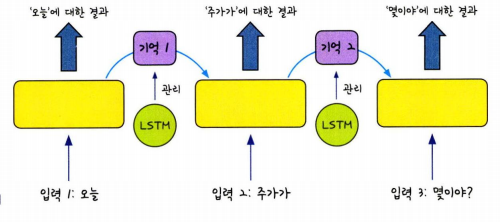

RNN 의 장점   

1. 다수 입력 단일 출력 ex) 문장을 읽고 뜻을 파악할 때
2. 단일 입력 다수 출력 ex) 사진의 캡션을 만들 때
3. 다수 입력 다수 출력 ex) 문장을 번역할 때

#### 모듈 종합, seed 값 설정

In [ ]:
from keras.datasets import reuters
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding
from keras.preprocessing import sequence
from keras.utils import np_utils

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
seed = 0
np.random.seed(seed)
tf.random.set_seed(3)

### LSTM 활용한 '로이터 뉴스 카테고리' 분류

로이터 뉴스 데이터셋 불러오기 (text data)
  - 11,228개 뉴스 기사 + 46개 카테고리


In [ ]:
from keras.datasets import reuters

train data / test data 로 분할
  - reuters.load_data() : 기사 불러오기
  - num_words : 빈도 수가 높은 단어만 불러오기 ( 나머지는 버림 )
  - test_split = 0.2  ㅡ> 20% 테스트셋으로 활용

In [ ]:
(X_train, Y_train), (X_test, Y_test) = reuters.load_data(num_words=1000, test_split=0.2)

2113536/2110848 [==============================] - 0s 0us/step


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


#### 데이터 살펴보기

In [ ]:
X_train.shape

(8982,)

In [ ]:
X_train[:5]

array([list([1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 2, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 2, 2, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 2, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]),
       list([1, 2, 699, 2, 2, 56, 2, 2, 9, 56, 2, 2, 81, 5, 2, 57, 366, 737, 132, 20, 2, 7, 2, 49, 2, 2, 2, 2, 699, 2, 8, 7, 10, 241, 16, 855, 129, 231, 783, 5, 4, 587, 2, 2, 2, 775, 7, 48, 34, 191, 44, 35, 2, 505, 17, 12]),
       list([1, 53, 12, 284, 15, 14, 272, 26, 53, 959, 32, 818, 15, 14, 272, 26, 39, 684, 70, 11, 14, 12, 2, 18, 180, 183, 187, 70, 11, 14, 102, 32, 11, 29, 53, 44, 704, 15, 14, 19, 758, 15, 53, 959, 47, 2, 15, 14, 19, 132, 15, 39, 965, 32, 11, 14, 147, 72, 11, 180, 183, 187, 44, 11, 14, 102, 19, 11, 123, 186, 90, 67, 960, 4, 78, 13, 68, 467, 511, 110, 59, 89, 90, 67, 2, 55, 2, 92, 617, 80, 2, 46, 905, 220, 13,

In [ ]:
Y_train.shape

(8982,)

In [ ]:
Y_train[:5]

array([3, 4, 3, 4, 4])

뉴스 기사의 최대 길이: 2376
뉴스 기사의 평균 길이: 145.539857


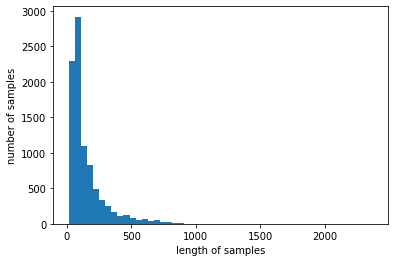

In [ ]:
print('뉴스 기사의 최대 길이: %d' %(max(len(i) for i in X_train)))
print('뉴스 기사의 평균 길이: %f' %(sum(map(len, X_train))/len(X_train)))

plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')   # 뉴스 기사 평균 크기 보기
plt.show()

카테고리의 빈도 수

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


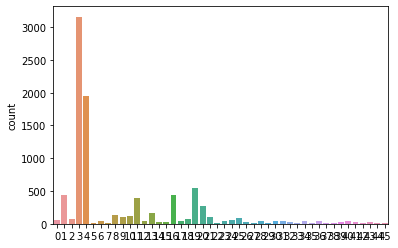

In [ ]:
import seaborn as sns
# 카테고리별 빈도수 보기
sns.countplot(Y_train) 
plt.show()

In [ ]:
Y_train[:100]

array([ 3,  4,  3,  4,  4,  4,  4,  3,  3, 16,  3,  3,  4,  4, 19,  8, 16,
        3,  3, 21, 11,  4,  4,  3,  3,  1,  3,  1,  3, 16,  1,  4, 13, 20,
        1,  4,  4, 11,  3,  3,  3, 11, 16,  4,  4, 20, 18, 25, 19,  3,  4,
        3,  4,  3,  4,  3,  3,  4,  4,  3,  4,  4,  3, 19, 35,  8,  4,  4,
        3, 16, 25,  3, 11,  3,  9, 16, 38, 10,  4,  4,  9,  3,  3, 28, 20,
        3,  3,  3,  3,  3,  4,  4,  3,  4,  2,  3,  1,  3, 19,  4])

Y_train의 배열 원소값 범위가 0 ~ 45,

0부터 세기 때문에 +1을 더해 (45+1) 개

In [ ]:
category = np.max(Y_train) + 1

print(category, '카테고리')
print(len(X_train),'학습용 뉴스 기사')
print(len(X_test), '테스트용 뉴스 기사')
print(X_train[0])

46 카테고리
8982 학습용 뉴스 기사
2246 테스트용 뉴스 기사
[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 2, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 2, 2, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 2, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


중간 점검
1. 기사 안의 단어 중에서 거의 사용되지 않는 것들도 있을 것

2. 모든 단어를 다 사용하는 것은 비효율적, 빈도가 높은 단어만 불러와 사용함(num_word=1000)

3. 각 기사의 단어 수가 제각각 다르기에 이를 동일하게 맞춰줘야 함

### x, y 데이터 전처리

x 데이터 전처리
  - maxlen = [  ] : 단어 수를 [  ]개로 맞추다

  ex) maxlen = 100 일 때,

      입력된 기사의 단어 수 > 100 : 100개째 단어까지만 선택, 나머지는 버림

      입력된 기사의 단어 수 < 100 : 부족한 부분을 0으로 채움

In [ ]:
from keras.preprocessing import sequence

x_train = sequence.pad_sequences(X_train, 100)
x_test = sequence.pad_sequences(X_test, 100)

y 데이터 전처리
  - np_utils.to_categorical
  
  np_utils 패키지에 있는 to_categorical 이라는 함수

  = One-hot 인코딩을 해주는 함수



In [ ]:
from keras.utils import np_utils

y_train = np_utils.to_categorical(Y_train)
y_test = np_utils.to_categorical(Y_test)

### 딥러닝 구조 만들기

New) 새롭게 추가된 층 2개
  1. Embedding : 데이터 전처리를 통해 입력된 값을 받아서, 다음 층이 이해할 수 있는 형태로 변환
    * Embedding( '불러온 단어의 총 개수', '기사당 단어 수' )

      ★ 모델 설정의 맨 처음에 작성!


  2. LSTM : RNN에서 기억 값의 가중치를 조절
    * LSTM(기사당 단어 수, 기타 옵션)

모델 설정

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding

model = Sequential()
model.add(Embedding(1000,100))
model.add(LSTM(100, activation='tanh'))
model.add(Dense(46, activation='softmax'))

- RNN에서 왜 tanh 함수를 주로 사용할까?

  RNN의 기울기 소실 문제를 예방하기 위해서

  = 기울기가 최대한 오래 유지될 수 있도록 해주는 역할로

  sigmoid < tanh가 적합하기 때문

  참고사이트: https://brightwon.tistory.com/10?category=718167

모델 컴파일

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

모델 실행

In [ ]:
history = model.fit(x_train, y_train, validation_data=(x_test,y_test), batch_size=100, epochs=20)
print("\n Test Accuracy: %.4f" % (model.evaluate(x_test,y_test)[1]))

Epoch 1/20
90/90 [==============================] - 24s 245ms/step - loss: 2.9665 - accuracy: 0.3179 - val_loss: 2.1698 - val_accuracy: 0.4488
Epoch 2/20
90/90 [==============================] - 21s 236ms/step - loss: 2.0567 - accuracy: 0.4787 - val_loss: 1.9425 - val_accuracy: 0.5013
Epoch 3/20
90/90 [==============================] - 21s 236ms/step - loss: 1.8856 - accuracy: 0.5164 - val_loss: 1.8027 - val_accuracy: 0.5352
Epoch 4/20
90/90 [==============================] - 21s 235ms/step - loss: 1.7841 - accuracy: 0.5442 - val_loss: 1.7418 - val_accuracy: 0.5623
Epoch 5/20
90/90 [==============================] - 21s 236ms/step - loss: 1.7226 - accuracy: 0.5517 - val_loss: 1.7070 - val_accuracy: 0.5668
Epoch 6/20
90/90 [==============================] - 21s 238ms/step - loss: 1.6403 - accuracy: 0.5853 - val_loss: 1.6144 - val_accuracy: 0.6015
Epoch 7/20
90/90 [==============================] - 21s 237ms/step - loss: 1.5713 - accuracy: 0.6046 - val_loss: 1.5567 - val_accuracy: 0.6171

epoch - loss 그래프

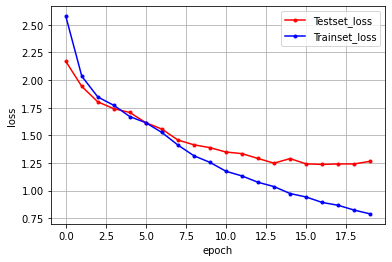

In [ ]:
# test set의 오차
y_vloss = history.history['val_loss']
# train set의 오차
y_loss = history.history['loss']

# 그래프로 표현
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label="Testset_loss")
plt.plot(x_len, y_loss, marker='.', c="blue", label="Trainset_loss")

# 그래프에 그리드 추가 & 레이블 표시
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

테스트 오차가 상승하기 전까지의 학습이

Overfitting 직전까지의 최적의 학습 시간이다!

#### 참고

reuters.get_word_index() : 각 단어와 그 단어에 부여된 인덱스를 리턴. 

이를 사용해서 빈도수에 맞는 단어를 확인이 가능하다.

In [ ]:
word_to_index = reuters.get_word_index()
index_to_word = {}
for key, value in word_to_index.items():
    index_to_word[value] = key

print('빈도수 상위 x번 단어 : %s'%(index_to_word[20000]))
print('빈도수 상위 1번 단어 : %s'%(index_to_word[1]))

빈도수 상위 x번 단어 : attiya
빈도수 상위 1번 단어 : the


기사 본문의 디코딩 작업을 통해 글자 확인해보기

In [ ]:
print(' '.join([index_to_word[X] for X in X_train[0]]))

the of of mln loss for plc said at only ended said of could 1 traders now april 0 a after said from 1985 and from foreign 000 april 0 prices its account year a but in this mln home an states earlier and rise and revs vs 000 its 16 vs 000 a but 3 of of several and shareholders and dividend vs 000 its all 4 vs 000 1 mln agreed of april 0 are 2 states will billion total and against 000 pct dlrs


참고 : https://blog.naver.com/cs00327/221942027672